# ECCO HEAT BUDGET - revised

### 13-tile native lat-lon-cap 90 grid
The lat-lon-cap (llc) is the decomposition of the spherical Earth into a Cartesian curvilinear coordinate system . It is a topologically non-trivial cubed-sphere rendering in the northern hemisphere and a dipolar grid in the southern hemisphere. Between 70°S and ~57°N, model grid cells are approximately oriented to lines of latitude and longitude. A special Arctic “cap” is situated north of ~57°N.

The Cartesian curvilinear coordinate system is divided into 13 tiles, each consisting of 90x90 grid cells in the horizontal and 50 vertical levels. Horizontal model grid resolution varies spatially from 22km to 110km, with the highest resolutions at high latitudes and lowest resolution in mid latitudes. Vertical grid spacing increases with depth from 10m to 456.5m. The bottom of the deepest model grid cell is 6145m below the surface.
https://ecco-v4-python-tutorial.readthedocs.io/fields.html

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.60.125:36219")
client

Client Scheduler: tcp://10.32.60.125:36219 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 3 Cores: 6 Memory: 34.50 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [4]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [5]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 35

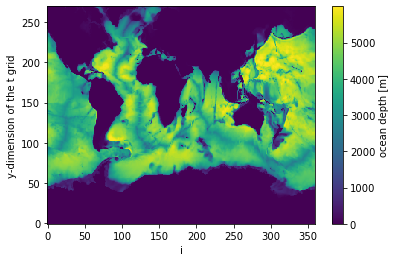

In [6]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=100).drop('i').plot()

In [69]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [70]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords()
ds = ds_ll_drop.reset_coords(drop=True)
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_TH    (time, k_l,

In [9]:
theta_rolled = ds.THETA.roll(i=100)#.drop('i')
sst_mean_test = theta_rolled.sel(k=0).mean(dim='time').load()

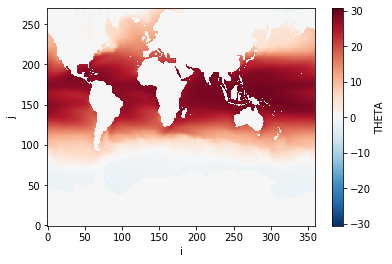

In [10]:
sst_mean_test.plot()

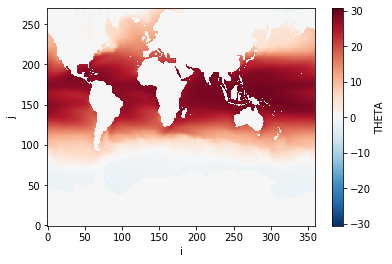

In [11]:
sst_mean = ds.THETA.roll(i=100).sel(k=0).mean(dim='time').load()
sst_mean.plot()

In [12]:
surface_mask = (coords.roll(i=100).hFacC[0]>0).load()
surface_mask

<xarray.DataArray 'hFacC' (j: 270, i: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: j, i

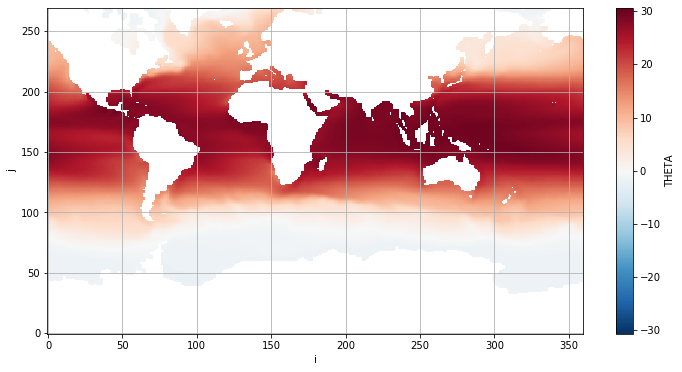

In [15]:
sst_mean.where(surface_mask).plot(figsize=(12,6))
plt.grid();

In [29]:
sst_mean_wg = sst_mean.sel(i=slice(55, 150), j=slice(30, 80))
surface_mask_wg = surface_mask.sel(i=slice(55, 150), j=slice(30, 80))

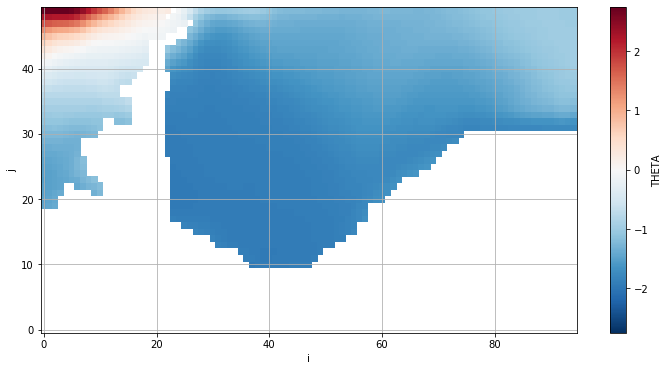

In [30]:
sst_mean_wg.where(surface_mask_wg).plot(figsize=(12,6))
plt.grid();

In [54]:
left_i = 21
right_i = 90
upper_j = 44
lower_j = 9

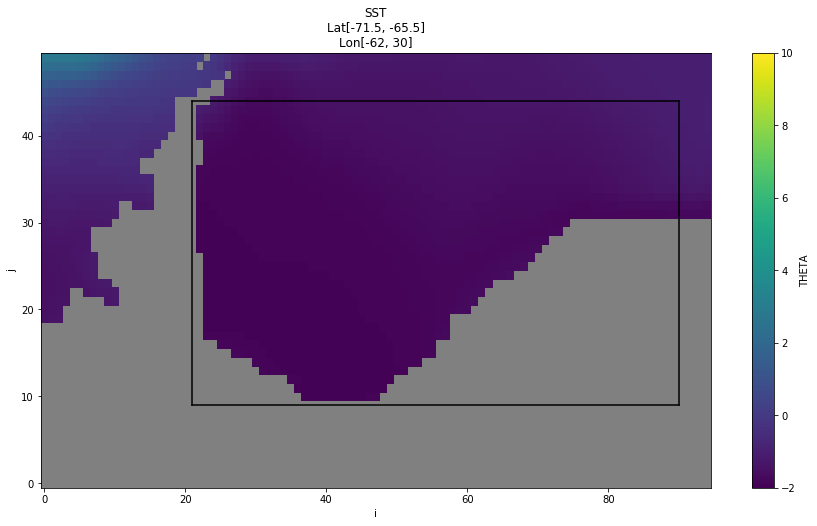

In [55]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg.where(surface_mask_wg).plot(ax=ax,  vmin=-2, vmax=10)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

### Slice whole dataset for WG region to minimize computation cost

In [61]:
ds_wg = ds.sel(i=slice(55, 150), j=slice(30, 80)).roll(i=100)
coords_wg = coords.sel(i=slice(55, 150), j=slice(30, 80)).roll(i=100)

In [68]:
ds_wg

<xarray.Dataset>
Dimensions:    (face: 13, i: 95, i_g: 360, j: 50, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Dimensions without coordinates: i, j, k
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 50, 95), chunksize=(1, 50, 50, 35)>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 50, 95), 

In [62]:
mean_sst_wg = ds_wg.THETA.sel(k=0).mean(dim='time').load()
mean_sst_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [-0.737826, -0.690416, -0.646709, ..., -0.904676, -0.844827, -0.788562],
       [-0.607514, -0.567345, -0.524272, ..., -0.744931, -0.693225, -0.648097],
       [-0.467102, -0.439457, -0.401929, ..., -0.556823, -0.519217, -0.490949]],
      dtype=float32)
Dimensions without coordinates: j, i

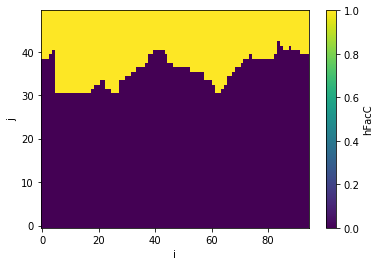

In [66]:
surface_mask_wg1 = (coords_wg.hFacC[0]>0).load()
surface_mask_wg1.plot()

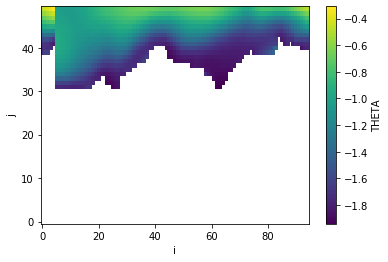

In [64]:
mean_sst_wg.where(surface_mask_wg1).plot()